In [42]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

In [87]:
prefix = '/home/shane/minerl/DiamondsInTheRough/log_parser/logs/'

experiments = {
    'PDDDQN': 'shane_logs/',
    'Rainbow': 'bre_logs/',
    'SQIL': 'nico_logs/tree_chop_1/',
    #'DQfD': 'daniel_logs/',

#    'k_16': 'result/85a45807b34265153c1859459809b9d49691a674-653f3a8f-ea8043ef/',
#    'lr_0002': 'lr-0.0002/85a45807b34265153c1859459809b9d49691a674-653f3a8f-d16ce028/',
#    'lr_0002_long': 'lr-0.0002_long/85a45807b34265153c1859459809b9d49691a674-653f3a8f-bc8811fd/',
#    'lr_000125_k16': 'result/85a45807b34265153c1859459809b9d49691a674-653f3a8f-9f5c89e5/',
    #'lr_000125_k20': 'lr-0.000125_k20/85a45807b34265153c1859459809b9d49691a674-653f3a8f-08eddedb/'
    
}

experiments = {k: prefix + v for k, v in experiments.items()}

In [88]:
rx_dict = {
    'statistics': re.compile(r"statistics:(?P<statistics>.*)\n"),
    'result': re.compile(r"outdir:.* (?P<result>step:(\d+) episode:(\d+) R:(.*))\n")
}
def _parse_line(line):
    for key, rx in rx_dict.items():
        match = rx.search(line)
        if match:
            #print(key)
            return key, match
    return None, None

In [89]:
# instead, join on episode. But, have to join the lines
train_losses = pd.DataFrame()
train_q_values = pd.DataFrame()
train_rewards = pd.DataFrame()

for name, path in experiments.items():
    statistics = []
    rewards = []
    
    # read the log file, parse the fields, create a statistics and rewards list
    with open(f"{path}log.txt", 'r') as f:
        for line in f:
            key, match = _parse_line(line)
            if key == 'statistics':
                # replace nan with 0
                stats = match.group('statistics').replace('nan', '0.0')
                # convert the list of tuples into a dict
                statistics.append(dict(eval(stats)))

            if key == 'result':
                result = match.group('result').replace('nan', '0.0').split()
                rewards.append(dict(map(lambda s : s.split(':'), result)))

        
        
        df = pd.DataFrame(rewards).apply(pd.to_numeric).set_index('episode')
        df = df.join(pd.DataFrame(statistics).set_index('cumulative_steps'), on='step')
        train_losses = pd.concat([train_losses, df['average_loss'].rename(name)], axis=1)
        train_q_values = pd.concat([train_q_values, df['average_q'].rename(name)], axis=1)
        train_rewards = pd.concat([train_rewards, df['R'].rename(name)], axis=1)

In [100]:
df_daniel_train = pd.read_csv('daniel_log.txt')
df_daniel_scores = pd.read_csv('daniel_scores.txt')

In [101]:
df_daniel_train.head()

,Unnamed: 0,step,episode,R,average_loss_1step,average_loss_nstep,average_loss_supervised,average_loss,n_updates
0,0,2000,0,0.0,0.220777,0.262876,0.505449,0.989102,500
1,2,4000,1,0.0,0.166023,0.211626,0.437048,0.814697,1000
2,4,6000,2,0.0,0.130795,0.193174,0.399649,0.723619,1500
3,6,8000,3,2.0,0.117520,0.165107,0.374587,0.657213,2000
4,8,10000,4,3.0,0.109200,0.156793,0.333441,0.599434,2500


In [102]:
train_losses = pd.concat([train_losses, df_daniel_train['average_loss'].rename('DQFD')], axis=1)
train_rewards = pd.concat([train_rewards, df_daniel_train['R'].rename('DQFD')], axis=1)

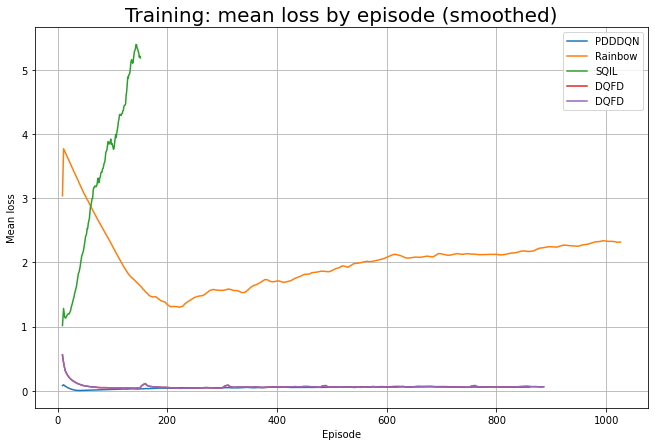

In [103]:
window = 10

fig, ax = plt.subplots(figsize=(11,7))
train_losses.rolling(window).mean().plot(ax=ax)

ax.set_title("Training: mean loss by episode (smoothed)", fontsize=20)
ax.set_xlabel('Episode')
ax.set_ylabel('Mean loss')
ax.grid()

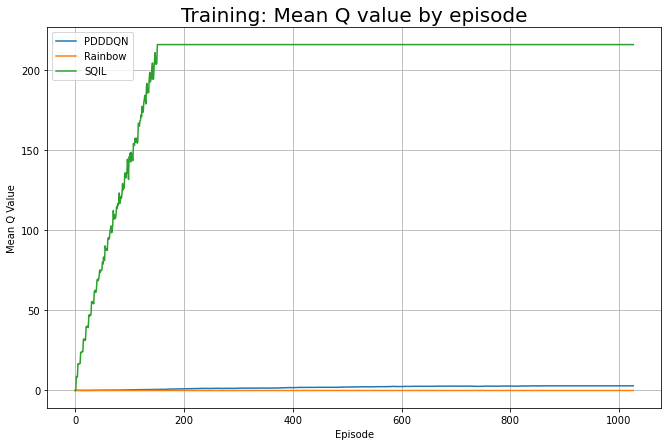

In [104]:
fig, ax = plt.subplots(figsize=(11,7))

train_q_values.interpolate().plot(ax=ax)

ax.set_title("Training: Mean Q value by episode", fontsize=20)
ax.set_xlabel('Episode')
ax.set_ylabel('Mean Q Value')
ax.grid()


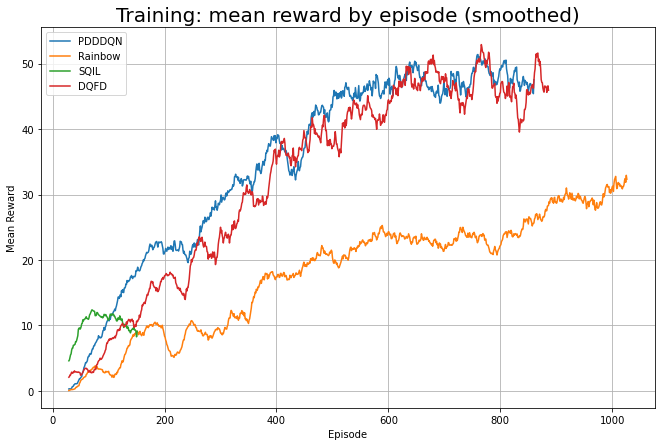

In [108]:
window = 30

fig, ax = plt.subplots(figsize=(11,7))

for name, series in train_rewards.iteritems():
    mean = series.rolling(window).mean()
    sigma = series.rolling(window).std()
    ax.plot(mean, label=name)
    # comment out to remove standard deviation spread
    #ax.fill_between(series.index.tolist(), mean+sigma, mean-sigma, alpha=0.25)
    
ax.set_title("Training: mean reward by episode (smoothed)", fontsize=20)
ax.legend(loc='upper left')
ax.set_xlabel('Episode')
ax.set_ylabel('Mean Reward')
ax.grid()

In [118]:
eval_losses = pd.DataFrame()
eval_q_values = pd.DataFrame()
eval_rewards = pd.DataFrame()

for name, path in experiments.items():
    df = pd.read_csv(f"{path}scores.txt", sep="\t").set_index('episodes')
    eval_losses = pd.concat([eval_losses, df['average_loss'].rename(name)], axis=1)
    eval_q_values = pd.concat([eval_q_values, df['average_q'].rename(name)], axis=1)
    eval_rewards = pd.concat([eval_rewards, df['mean'].rename(name)], axis=1) 

In [119]:
df

,steps,elapsed,mean,median,stdev,max,min,average_q,average_loss,cumulative_steps,n_updates,rlen
episodes,,,,,,,,,,,,
77,151279,19810.072979,13.05,14.0,5.614596,21.0,5.0,114.544235,3.738788,151279,36570,151279


In [120]:
df = pd.read_csv('daniel_scores.txt').set_index('e_episodes')
df.head()
df.index

Int64Index([ 25,  50,  75, 100, 126, 151, 176, 176, 201, 227, 252, 277, 302,
            327, 327, 352, 378, 404, 429, 455, 480, 505, 530, 556, 581, 507,
            532, 557, 583, 609, 635, 661, 686, 712, 739, 778, 804, 830, 856,
            883],
           dtype='int64', name='e_episodes')

In [117]:
eval_losses = pd.concat([eval_losses, df['e_average_loss'].rename('DQfD')], axis=1)

ValueError: Shape of passed values is (261, 4), indices imply (257, 4)

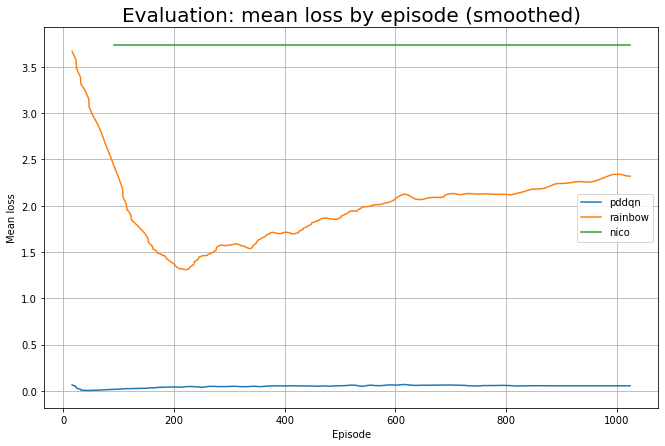

In [62]:
window = 3

fig, ax = plt.subplots(figsize=(11,7))

eval_losses.interpolate().rolling(window).mean().plot(ax=ax)

ax.set_title("Evaluation: mean loss by episode (smoothed)", fontsize=20)
ax.set_xlabel('Episode')
ax.set_ylabel('Mean loss')
ax.grid()

In [66]:
eval_rewards['nico'][eval_rewards['nico'].notna()]

77    13.05
Name: nico, dtype: float64

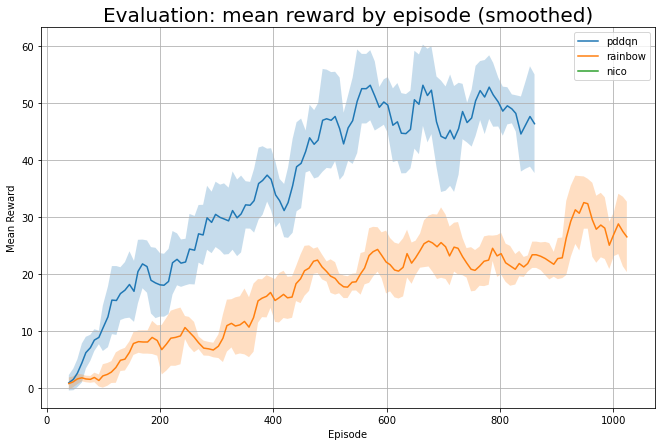

In [67]:
fig, ax = plt.subplots(figsize=(11,7))

# unsmoothed
#eval_rewards[:70].interpolate().plot(ax=ax)

# # smoothed versions
# window = 3
# eval_rewards[:30].rolling(window, min_periods=1).mean().plot(ax=ax)

window = 5
for name, series in eval_rewards.iteritems():
    series = series[series.notna()]
    mean = series.rolling(window).mean()
    sigma = series.rolling(window).std()
    ax.plot(mean, label=name)
#     # comment out to remove standard deviation spread
    ax.fill_between(series.index.tolist(), mean+sigma, mean-sigma, alpha=0.25)
ax.legend()
ax.set_title("Evaluation: mean reward by episode (smoothed)", fontsize=20)
ax.set_xlabel('Episode')
ax.set_ylabel('Mean Reward')
ax.grid()

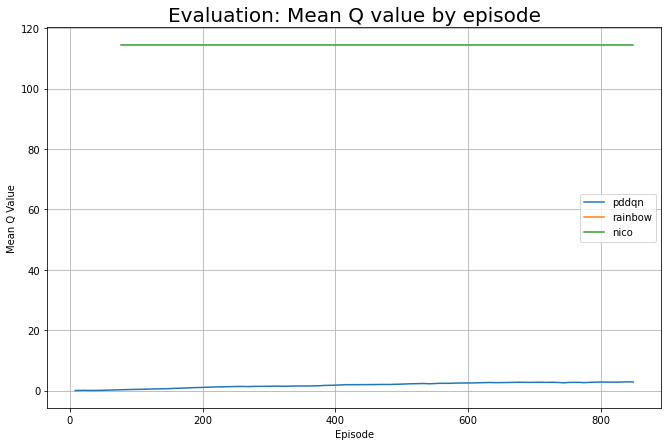

In [68]:
fig, ax = plt.subplots(figsize=(11,7))

eval_q_values[:200].interpolate().plot(ax=ax)

ax.set_title("Evaluation: Mean Q value by episode", fontsize=20)
ax.set_xlabel('Episode')
ax.set_ylabel('Mean Q Value')
ax.grid()